# Integrator RNN tutorial

In this notebook, we train a vanilla RNN to integrate white noise.  This example is useful on its own to understand how RNN training works, and how to use JAX.  In addition, it provides the input for the LFADS JAX tutorial. 

### Imports

In [1]:
# Numpy, JAX, Matplotlib and h5py should all be correctly installed and on the python path.
from __future__ import print_function, division, absolute_import
import datetime
import h5py
import jax.numpy as np
from jax import grad, jit, vmap
from jax import random
from jax import jacrev, jacfwd
from jax.experimental import optimizers
import jax.experimental.stax as stax
import jax.flatten_util as flatten_util
import matplotlib.pyplot as plt
import numpy as onp             # original CPU-backed NumPy
import time

In [2]:
# Import the tutorial code.

# You must change this to the location of computation-thru-dynamics directory.
HOME_DIR = '/home/sussillo/' 

import os
import sys

sys.path.append(os.path.join(HOME_DIR,'computation-thru-dynamics'))
import integrator_rnn_tutorial.integrator as integrator
import integrator_rnn_tutorial.rnn as rnn
import integrator_rnn_tutorial.utils as utils

### Hyperparameters

In [3]:
# Integration parameters
T = 1.0          # Arbitrary amount time, roughly physiological.
ntimesteps = 25  # Divide T into this many bins
bval = 0.01      # bias value limit
sval = 0.025     # standard deviation (before dividing by sqrt(dt))
input_params = (bval, sval, T, ntimesteps)

# Integrator RNN hyperparameters
u = 1         # Number of inputs to the RNN
n = 100       # Number of units in the RNN
o = 1         # Number of outputs in the RNN

# The scaling of the recurrent parameters in an RNN really matters. 
# The correct scaling is 1/sqrt(number of recurrent inputs), which 
# yields an order 1 signal output to a neuron if the input is order 1.
# Given that VRNN uses a tanh nonlinearity, with min and max output 
# values of -1 and 1, this works out.  The scaling just below 1 
# (0.95) is because we know we are making a line attractor so, we 
# might as well start it off basically right 1.0 is also basically 
# right, but perhaps will lead to crazier dynamics.
param_scale = 0.85 # Scaling of the recurrent weight matrix

# Optimization hyperparameters
num_batchs = 10000         # Total number of batches to train on.
batch_size = 128          # How many examples in each batch
eval_batch_size = 1024    # How large a batch for evaluating the RNN
step_size = 0.025          # initial learning rate
decay_factor = 0.99975     # decay the learning rate this much
# Gradient clipping is HUGELY important for training RNNs
max_grad_norm = 10.0      # max gradient norm before clipping, clip to this value.
l2reg = 0.0002           # amount of L2 regularization on the weights
adam_b1 = 0.9             # Adam parameters
adam_b2 = 0.999
adam_eps = 1e-1
print_every = 100          # Print training informatino every so often

Seed: 203229


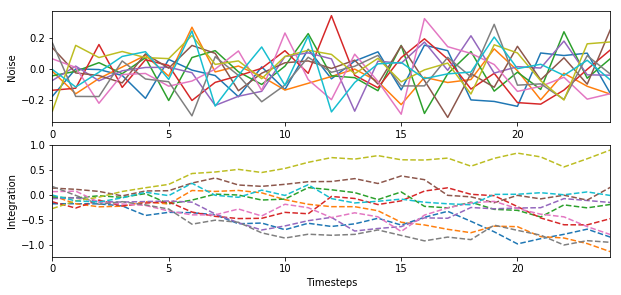

In [4]:
# JAX handles randomness differently than numpy or matlab. 
# one threads the randomness through to each function. 
#  It's a bit tedious, but very easy to understand and with
# reliable effect.
seed = onp.random.randint(0, 1000000) # get randomness from CPU level numpy
print("Seed: %d" % seed)
key = random.PRNGKey(seed) # create a random key for jax for use on device.

# Plot a few input/target examples to make sure things look sane.
ntoplot = 10    # how many examples to plot
# With this split command, we are always getting a new key from the old key,
# and I use first key as as source of randomness for new keys.
#     key, subkey = random.split(key, 2)
#     ## do something random with subkey
#     key, subkey = random.split(key, 2)
#     ## do something random with subkey
# In this way, the same top level randomness source stays random.

# The number of examples to plot is given by the number of 
# random keys in this function.
key, skey = random.split(key, 2)
skeys = random.split(skey, ntoplot) # get ntoplot random keys
inputs, targets = integrator.build_inputs_and_targets_jit(input_params, skeys)

# Plot the input to the RNN and the target for the RNN.
integrator.plot_batch(ntimesteps, inputs, targets)

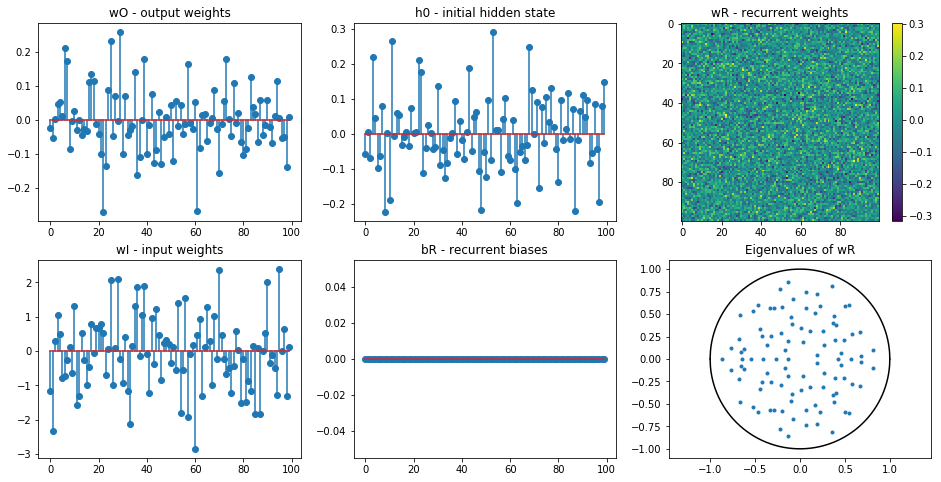

In [5]:
# Init some parameters for training.
key, subkey = random.split(key, 2)
init_params = rnn.random_vrnn_params(subkey, u, n, o, g=param_scale)
rnn.plot_params(init_params)

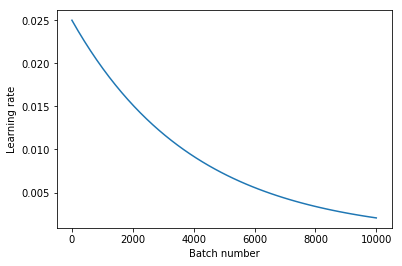

In [6]:
# Create a decay function for the learning rate
decay_fun = optimizers.exponential_decay(step_size, decay_steps=1, 
                                         decay_rate=decay_factor)

batch_idxs = onp.linspace(1, num_batchs)
plt.plot(batch_idxs, [decay_fun(b) for b in batch_idxs])
plt.axis('tight')
plt.xlabel('Batch number')
plt.ylabel('Learning rate');

### Train the VRNN

In [7]:
# Initialize the optimizer.  Please see jax/experimental/optimizers.py
opt_init, opt_update = optimizers.adam(decay_fun, adam_b1, adam_b2, adam_eps)
opt_state = opt_init(init_params)

# Run the optimization loop, first jit'd call will take a minute.
start_time = time.time()
all_train_losses = []
for batch in range(num_batchs):
    key, subkey = random.split(key, 2)
    skeys = random.split(subkey, batch_size)
    inputs, targets = integrator.build_inputs_and_targets_jit(input_params, skeys)
    opt_state = rnn.update_w_gc_jit(batch, opt_state, opt_update, inputs,
                                  targets, max_grad_norm, l2reg)
    if batch % print_every == 0:
        params = optimizers.get_params(opt_state)
        all_train_losses.append(rnn.loss_jit(params, inputs, targets, l2reg))
        train_loss = all_train_losses[-1]['total']
        batch_time = time.time() - start_time
        step_size = decay_fun(batch)
        s = "Batch {} in {:0.2f} sec, step size: {:0.5f}, training loss {:0.4f}"
        print(s.format(batch, batch_time, step_size, train_loss))
        start_time = time.time()
        
# List of dicts to dict of lists
all_train_losses = {k: [dic[k] for dic in all_train_losses] for k in all_train_losses[0]}

Batch 0 in 5.58 sec, step size: 0.02500, training loss 0.1725
Batch 100 in 0.74 sec, step size: 0.02438, training loss 0.0429
Batch 200 in 0.77 sec, step size: 0.02378, training loss 0.0407
Batch 300 in 0.75 sec, step size: 0.02319, training loss 0.0368
Batch 400 in 0.75 sec, step size: 0.02262, training loss 0.0386
Batch 500 in 0.72 sec, step size: 0.02206, training loss 0.0362
Batch 600 in 0.75 sec, step size: 0.02152, training loss 0.0375
Batch 700 in 0.75 sec, step size: 0.02099, training loss 0.0354
Batch 800 in 0.76 sec, step size: 0.02047, training loss 0.0349
Batch 900 in 0.71 sec, step size: 0.01996, training loss 0.0337
Batch 1000 in 0.72 sec, step size: 0.01947, training loss 0.0341
Batch 1100 in 0.73 sec, step size: 0.01899, training loss 0.0322
Batch 1200 in 0.76 sec, step size: 0.01852, training loss 0.0336
Batch 1300 in 0.76 sec, step size: 0.01806, training loss 0.0308
Batch 1400 in 0.74 sec, step size: 0.01762, training loss 0.0311
Batch 1500 in 0.73 sec, step size: 0.

Text(0.5,1,'All losses')

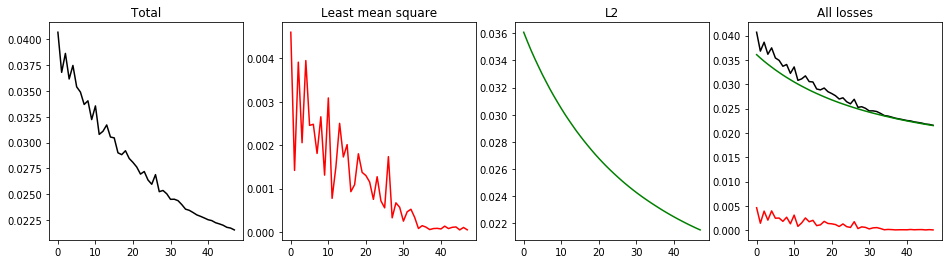

In [8]:
# Show the loss through training.
xlims = [2, 50]
plt.figure(figsize=(16,4))
plt.subplot(141)
plt.plot(all_train_losses['total'][xlims[0]:xlims[1]], 'k')
plt.title('Total')

plt.subplot(142)
plt.plot(all_train_losses['lms'][xlims[0]:xlims[1]], 'r')
plt.title('Least mean square')

plt.subplot(143)
plt.plot(all_train_losses['l2'][xlims[0]:xlims[1]], 'g');
plt.title('L2')

plt.subplot(144)
plt.plot(all_train_losses['total'][xlims[0]:xlims[1]], 'k')
plt.plot(all_train_losses['lms'][xlims[0]:xlims[1]], 'r')
plt.plot(all_train_losses['l2'][xlims[0]:xlims[1]], 'g')
plt.title('All losses')

### Testing

In [9]:
# Take a batch for an evalulation loss, notice the L2 penalty is 0
# for the evaluation.
params = optimizers.get_params(opt_state)

key, subkey = random.split(key, 2)
skeys = random.split(subkey, batch_size)
inputs, targets = integrator.build_inputs_and_targets_jit(input_params, skeys)
eval_loss = rnn.loss_jit(params, inputs, targets, l2reg=0.0)['total']
eval_loss_str = "{:.5f}".format(eval_loss)
print("Loss on a new large batch: %s" % (eval_loss_str))

Loss on a new large batch: 0.00003


### Visualizations of trained system

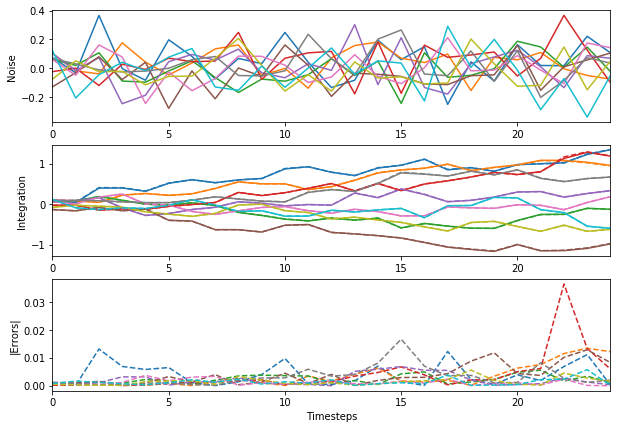

In [10]:
# Visualize how good this trained integrator is
inputs_and_targets = \
    lambda keys: integrator.build_inputs_and_targets_jit(input_params, keys)
rnn_run = lambda inputs: rnn.batched_rnn_run(params, inputs)

rnn_internals = rnn.run_trials(rnn_run, inputs_and_targets, 1, 16)

integrator.plot_batch(ntimesteps, rnn_internals['inputs'], 
                      rnn_internals['targets'], rnn_internals['outputs'], 
                      onp.abs(rnn_internals['targets'] - rnn_internals['outputs']))

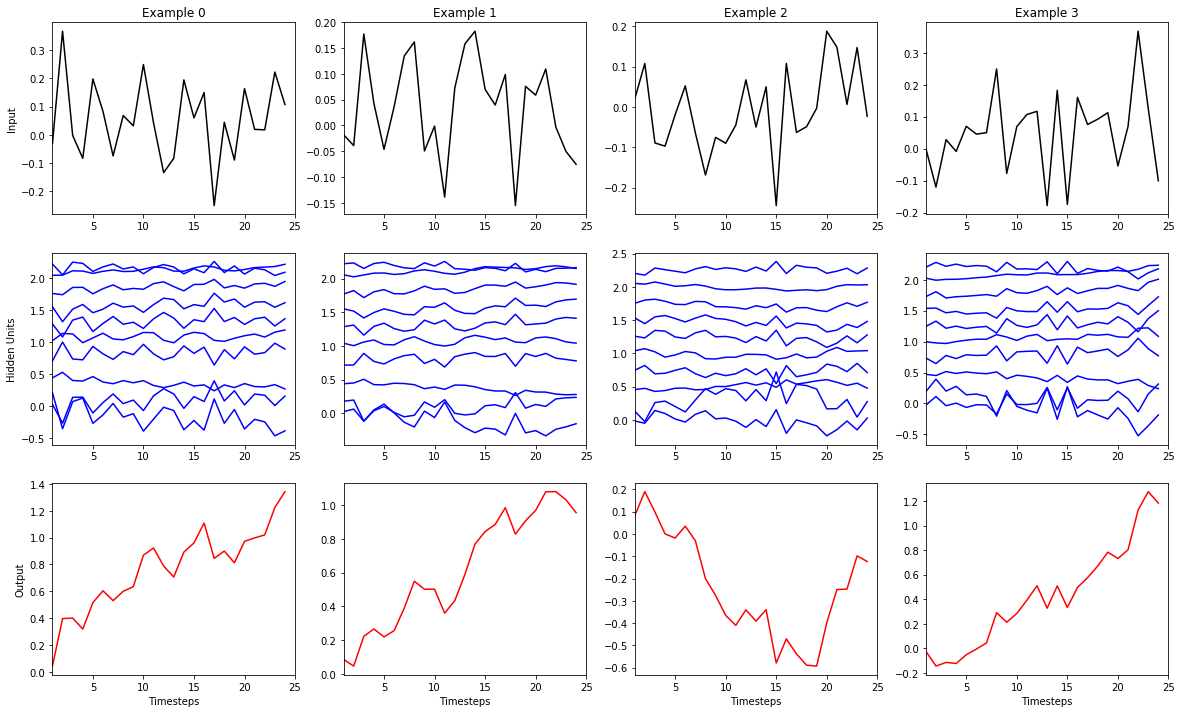

In [11]:
# Visualize the hidden state, as an example.
rnn.plot_examples(ntimesteps, rnn_internals, nexamples=4)

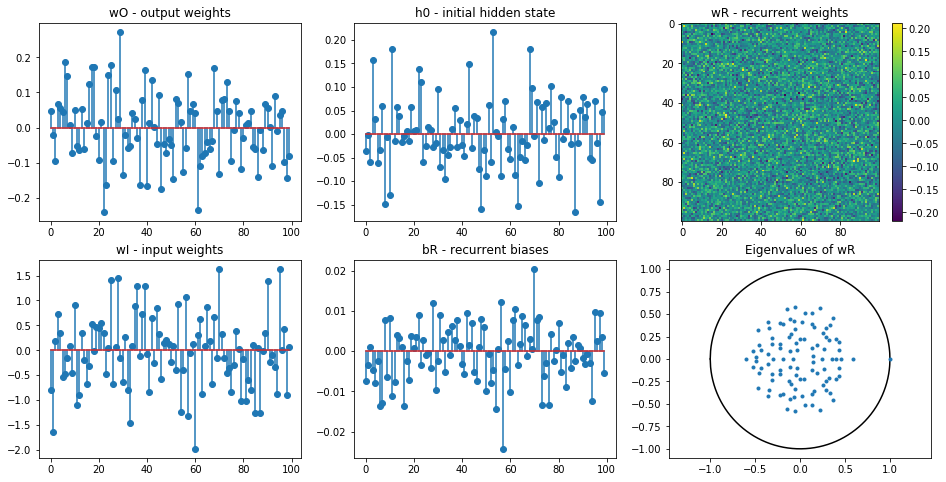

In [12]:
# Take a look at the trained parameters.
rnn.plot_params(params)

### Saving

In [13]:
# Define directories, etc.
task_type = 'pure_int'
rnn_type = 'vrnn'
fname_uniquifier = datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
data_dir = os.path.join(os.path.join('/tmp', rnn_type), task_type)

print(data_dir)
print(fname_uniquifier)

/tmp/vrnn/pure_int
2019-03-23_21:46:32


In [14]:
# Save parameters

params_fname = ('trained_params_' + rnn_type + '_' + task_type + '_' + \
                eval_loss_str + '_' + fname_uniquifier + '.h5')
params_fname = os.path.join(data_dir, params_fname)

print("Saving params in %s" % (params_fname))
utils.write_file(params_fname, params)

Saving params in /tmp/vrnn/pure_int/trained_params_vrnn_pure_int_0.00003_2019-03-23_21:46:32.h5


In [15]:
### Save some trials, this is for the LFADS tutorial, and no need 
### to save this otherwise.

# Save about 10,000 trials for playing around with the LFADS tutorial.
nsave_batches = 10 # Save about 10000 trials

data_fname = ('trained_data_' + rnn_type + '_' + task_type + '_' + \
              eval_loss_str + '_' + fname_uniquifier + '.h5')
data_fname = os.path.join(data_dir, data_fname)

inputs_and_targets = \
    lambda keys: integrator.build_inputs_and_targets_jit(input_params, keys)
rnn_run = lambda inputs: rnn.batched_rnn_run(params, inputs)
data_dict = rnn.run_trials(rnn_run, inputs_and_targets, nsave_batches,
                           eval_batch_size)
print("Saving data in %s" %(data_fname))
utils.write_file(data_fname, data_dict)

Saving data in /tmp/vrnn/pure_int/trained_data_vrnn_pure_int_0.00003_2019-03-23_21:46:32.h5
